## Imports

In [1]:
from dataset.dataset import MultiModalDataset
import PIL
import matplotlib.pyplot as plt
from mmaction.datasets import build_dataset
import torch
import os
import mmcv
import numpy as np
import torchvision
from PIL import Image

/home/sadat/miniconda3/envs/mmsign/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
os.chdir('../../..')

## Function to display image

In [3]:
def imshow(tensor, idx=0):
    plt.imshow(tensor.permute(1, 2, 3, 0)[idx])
    plt.axis('off')

## Multimodal Dataset

In [118]:
train_dataset = MultiModalDataset(ann_file='data/wlasl/train_annotations.txt',
                                 root_dir='data/wlasl/rawframes',
                                 clip_len=32,
                                 resolution=224,
                                 modalities=('rgb', 'pose', 'depth'),
                                 test_mode=True,
                                 frame_interval=1,
                                 input_resolution=256,
                                 num_clips=1)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=False)

In [119]:
iter_ = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


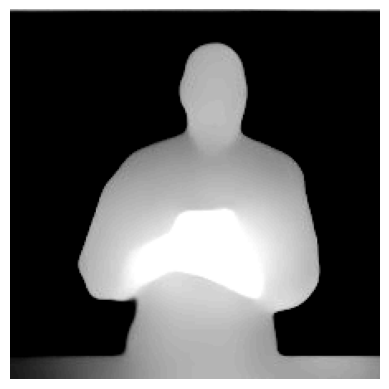

In [155]:
frame = next(iter_)
imshow(frame['depth'][0])

In [24]:
results = train_dataset.load_video(idx=543)

543


## Padding

In [8]:
results['body_bbox'][0].size

(224, 224)

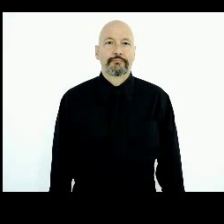

In [26]:
results['face'][0]

In [10]:
img = results['body_bbox'][0]

In [11]:
w, h = results['body_bbox'][0].size
w,h

(224, 224)

In [12]:
x0, y0, x1, y1 = [int(value) for value in results['pose'][0]['face']]
x0, y0, x1, y1

(37, 187, -38, 111)

In [13]:
pad_left=0
pad_right=0
pad_up=0
pad_down=0

if(x0<0):
    pad_left=-x0
if(x1>w):
    pad_right=x1-w
if(y0<0):
    pad_up=-y0
if(y1>h):
    pad_down=y1-h

x0=pad_left
x1=w+pad_left
y0=pad_up
y1=h+pad_up

In [14]:
pad_left, pad_right, pad_up, pad_down

(0, 0, 0, 0)

In [15]:
x0, y0, x1, y1

(0, 0, 224, 224)

In [16]:
h+pad_up+pad_down, w+pad_left+pad_right

(224, 224)

In [17]:
padded = np.zeros((h+pad_up+pad_down, w+pad_left+pad_right, 3), dtype=np.uint8)

In [18]:
padded[y0:y1, x0:x1] = img

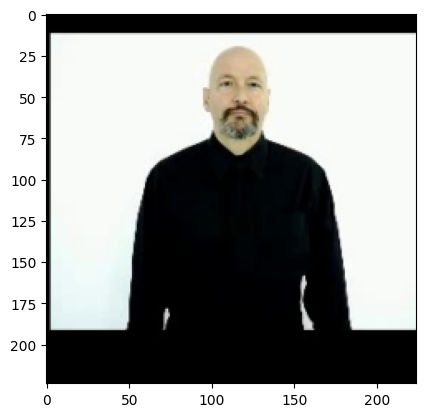

In [19]:
plt.imshow(padded)

## Crop

In [20]:
x0, y0, x1, y1 = [int(value) for value in results['pose'][0]['face']]
if x0<0:
    x0=0
    
if y0<0:
    y0=0

x0,x1,y0,y1

(37, -38, 187, 111)

In [21]:
# if(part=='head'):
x1a = x1
x1 = y1
y1a = y1
y1 = x1a

x0a = x0
x0= y0
y0a = y0
y0  = x0a

In [22]:
x0,x1,y0,y1

(187, 111, 37, -38)

ValueError: zero-size array to reduction operation minimum which has no identity

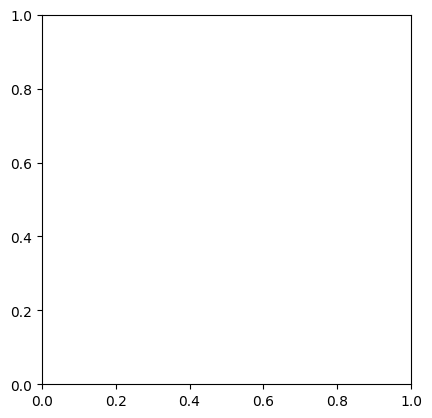

In [23]:
plt.imshow(padded[y0:y1, x0:x1])

In [ ]:
padded[y0:y1, x0:x1].shape

In [ ]:
part='right_hand'
rgbcrop =[]
rgb = results['rgb'] if part == 'body_bbox' else results['body_bbox']
w, h = rgb[0].size

for i, frame in enumerate(rgb):
    img =  np.array(frame)           

    bodybbox = results['pose'][i][part]
    pad = 0
    x0 = bodybbox[0]
    if(x0<0):
        x0 = 0
        pad = 1
    x1 = bodybbox[2]
    if(x1>w):
        x1 = w
        pad = 1
    y0 = bodybbox[1]
    if(y0<0):
        y0=0
        pad = 1
    y1 = bodybbox[3]
    if(y1>h):
        y1=h
        pad = 1
    ######################################### TEMP FIX ########## fix preprocess/main
    if(results=='head'):
        x1a = x1
        x1 = y1
        y1a = y1
        y1 = x1a

        x0a = x0
        x0= y0
        y0a = y0
        y0  = x0a
    x1 = int(x1)
    y0 = int(y0)
    y1 = int(y1)
    x0 = int(x0)             
    ###########################################
    #img = cv2.rectangle(img, (x0,y0), (x1,y1), (40,100,0),1)
    #cv2.imshow("", img)
    #cv2.waitKey(0)

    img = img[x0:x1, y0:y1].copy()
    if(pad):
        padimage = np.zeros((h,w,3), np.uint8)

        padimage[x0:x1,y0:y1] = img

        img = padimage.copy()

    img = Image.fromarray(img)

    if part != 'body_bbox':
        resize = torchvision.transforms.Resize(size=(224, 224))
        img = resize(img)

    rgbcrop.append(img)

results[part]= rgbcrop

In [ ]:
padimage[x0:x1, y0:y1].shape

In [ ]:
padimage[x0:x1,y0:y1] = img
plt.imshow(padimage)

In [ ]:
x0, y0, x1, y1

In [ ]:
plt.imshow(img)

In [ ]:
padimage.shape

In [ ]:
results['body_bbox'][0].size

In [ ]:
w, h

In [ ]:
img.shape

## Visualise

In [ ]:
key = 'pose'
results = train_dataset.load_video(idx=1)
# results = train_dataset.transforms(results)  
for i in range(len(results[key])): 
    body_bbox = [int(value) for value in results['pose'][i]['body_bbox']]
    img = results['rgb'][i]
    img =  np.array(img)[body_bbox[0]:body_bbox[2], body_bbox[1]:body_bbox[3]]
    

    if(key=='pose'):
        keypoints = results['pose'][i]['keypoints']
        for j in keypoints:
            img = cv2.circle(img, (int(keypoints[j]['x']), int(keypoints[j]['y'])), radius=1, color=(0, 0, 255), thickness=1)
        plt.imshow(img)
        break

## Crop Face

In [ ]:
key = 'pose'
results = train_dataset.load_video(idx=1)
# results = train_dataset.transforms(results)  
for i in range(len(results[key])): 
    body_bbox = [int(value) for value in results['pose'][i]['body_bbox']]
    face = [int(value) for value in results['pose'][i]['face']]
    img = results['rgb'][i]
    img =  np.array(img)[body_bbox[0]:body_bbox[2], body_bbox[1]:body_bbox[3]]
    img =  np.array(img)[face[0]:face[2], face[1]:face[3]]
    

    if(key=='pose'):
        keypoints = results['pose'][i]['keypoints']
        for j in keypoints:
            img = cv2.circle(img, (int(keypoints[j]['x']), int(keypoints[j]['y'])), radius=1, color=(0, 0, 255), thickness=1)

## Hand

In [ ]:
key = 'pose'
results = train_dataset.load_video(idx=1)
# results = train_dataset.transforms(results)  
w,h = results['rgb'][0].size
for i in range(len(results[key])): 
    body_bbox = [int(value) for value in results['pose'][i]['body_bbox']]    
    img = results['rgb'][i]
    img =  np.array(img, np.uint8)[body_bbox[0]:body_bbox[2], body_bbox[1]:body_bbox[3]]
    
    x0, y0, x1, y1 = [int(value) for value in results['pose'][i]['left_hand']]
    
    pad = False
    
    if x0<0:
        x0=0
        pad=True
    if x1>w:
        x1=w
        pad=True
    if y0<0:
        y0=0
        pad=True
    if y1>h:
        y0=h
        pad=True
        
    img = img[x0:x1, y0:y1]
    
    if pad:
        pad_image = np.zeros((h,w,3), np.uint8)
        pad_image[x0:x1, y0:y1] = img
        
        img = pad_image    
    
    plt.imshow(img)

In [ ]:
x0, y0, x1, y1 = [int(value) for value in results['pose'][i]['left_hand']]

In [ ]:
[x0, y0, x1, y1]

In [ ]:
img = results['rgb'][0]

In [ ]:
img.size

In [ ]:
face = [int(value) for value in pose[0]['face']]

In [ ]:
face

In [ ]:
cropped_ = frame[face[0]:face[2], face[1]:face[3]]

In [ ]:
plt.imshow(frame[face[0]:face[2], face[1]:face[3]])

In [ ]:
x = next(iter_)

In [ ]:
x

In [ ]:
batch = next(iter_)
i=0
imshow(batch['depth'][0])

In [ ]:
len(batch)

In [ ]:
batch[0].shape, batch[1].shape, batch[2].shape

In [ ]:
x = torch.FloatTensor(1,32,256,256).unsqueeze(dim=1)

In [ ]:
x.shape

In [ ]:
y = torch.cat((x,x,x), dim=1)
y.shape

In [ ]:
rgb = batch[0]

In [ ]:
rgb[0].shape

In [ ]:
len(batch[0])

In [ ]:
rgb = batch[0][0].squeeze()

In [ ]:
rgb.shape

## Finding the normalise values

In [ ]:
# i=0
# r_mean = 0
# g_mean = 0
# b_mean = 0

# r_std = 0
# g_std = 0
# b_std = 0
# iter_ = iter(train_loader)

In [ ]:
# while i < len(train_loader):
#     batch = next(iter_)
#     rgb = batch['depth'][0]

#     r_mean += rgb[0].mean().item()
#     g_mean += rgb[1].mean().item()
#     b_mean += rgb[2].mean().item()

#     r_std += rgb[0].std().item()
#     g_std += rgb[1].std().item()
#     b_std += rgb[2].std().item()

#     i+=1

In [ ]:
# r_mean/i, g_mean/i, b_mean/i

In [ ]:
# r_std/i, g_std/i, b_std/i

## MMCV Dataset

In [ ]:
# # Set up dataset
# train_cfg = dict(
#     type='RawframeDataset',
#     ann_file='data/wlasl/train_annotations.txt',
#     data_prefix='data/wlasl/rawframes',
#     pipeline=[
#         dict(
#             type='SampleFrames',
#             clip_len=32,
#             frame_interval=2,
#             num_clips=1),
#         dict(type='RawFrameDecode'),
#         dict(type='Resize', scale=(-1, 256)),
# #         dict(type='RandomResizedCrop', area_range=(0.4, 1.0)),
#         dict(type='Resize', scale=(224, 224), keep_ratio=False),
# #         dict(type='Flip', flip_ratio=0.5),
#         dict(
#             type='Normalize',
#             mean=[123.675, 116.28, 103.53],
#             std=[58.395, 57.12, 57.375],
#             to_bgr=False),
#         dict(type='FormatShape', input_format='NCTHW'),
#         dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
#         dict(type='ToTensor', keys=['imgs', 'label'])
#     ])

# train_dataset = build_dataset(train_cfg)

# test_cfg = dict(
#         type='RawframeDataset',
#         ann_file='data/wlasl/test_annotations.txt',
#         data_prefix='data/wlasl/rawframes',
#         test_mode=True,
#         pipeline=[
#             dict(
#                     type='SampleFrames',
#                     clip_len=32,
#                     frame_interval=2,
#                     num_clips=1,
#                     test_mode=True),
#             dict(type='RawFrameDecode'),
#             dict(type='Resize', scale=(-1, 256)),
#             dict(type='CenterCrop', crop_size=224),
#             dict(
#                 type='Normalize',
#                 mean=[123.675, 116.28, 103.53],
#                 std=[58.395, 57.12, 57.375],
#                 to_bgr=False),
#             dict(type='FormatShape', input_format='NCTHW'),
#             dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
#             dict(type='ToTensor', keys=['imgs'])
#         ])

# # Building the datasets
# test_dataset = build_dataset(test_cfg)

# mmcv_test_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                       batch_size=1,
#                                       shuffle=False,
#                                       num_workers=4,
#                                       pin_memory=True)

In [ ]:
img_iter = iter(mmcv_test_loader)

In [ ]:
x = next(img_iter)
mmcv_imgs = x['imgs']
imshow(mmcv_imgs.squeeze(), 0)

In [ ]:
batch = next(iter_)
i=0
imshow(batch[0][0])

In [ ]:
video_iter = iter(mmcv_imgs.squeeze().permute(1,2,3,0))

In [ ]:
plt.imshow(next(video_iter))
plt.axis('off')